In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import mapclassify
import contextily as ctx

In [58]:
data = pd.read_csv('../data/estimates.csv')
access = pd.read_csv('../data/food_access.csv')
counties = geopandas.read_file('../data/us_county_shp_files/')
fips = pd.read_csv('../data/state_fips.csv')
states = geopandas.read_file('../data/us_state_census/')

In [3]:
fips['fips'] = fips['fips'].astype(str)

In [4]:
ch = [str(0) + v for v in fips['fips'][:7].values] 

fips.loc[:6,'fips'] = ch

In [5]:
counties = counties.merge(fips,left_on='STATEFP',right_on='fips')

access[['CensusTract', 'State', 'County','lapophalfshare']].head()
access = access[(access['Urban'] == 1)]
by_county = access.groupby(['County','State']).agg({'lapophalfshare':'mean'})

In [6]:
county_by_access = counties.merge(by_county, left_on = ['NAME','state'], right_on = ['County','State'])

In [7]:
county_by_access

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,abv,fips,lapophalfshare
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",Nebraska,NE,31,0.643003
1,31,101,00835872,31101,Keith,Keith County,06,H1,G4020,None,...,A,2749531879,124672190,+41.1942448,-101.6444493,"POLYGON ((-101.44325 41.00318, -101.46080 41.0...",Nebraska,NE,31,0.382065
2,31,137,00835890,31137,Phelps,Phelps County,06,H1,G4020,None,...,A,1398048600,1646533,+40.5163647,-099.4065568,"POLYGON ((-99.64389 40.43768, -99.64380 40.442...",Nebraska,NE,31,0.516916
3,31,043,00835843,31043,Dakota,Dakota County,06,H1,G4020,None,...,A,684463003,8152947,+42.3916449,-096.5613555,"POLYGON ((-96.72622 42.39460, -96.72626 42.399...",Nebraska,NE,31,0.552650
4,31,089,00835866,31089,Holt,Holt County,06,H1,G4020,None,...,A,6248078943,13204318,+42.4592867,-098.7847662,"POLYGON ((-99.24591 42.69551, -99.24594 42.695...",Nebraska,NE,31,0.596896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157,44,009,01219782,44009,Washington,Washington County,06,H4,G4020,148,...,N,852827550,604769784,+41.3967920,-071.6202819,"MULTIPOLYGON (((-71.52243 41.60257, -71.52208 ...",Rhode Island,RI,44,0.827176
2158,44,007,01219781,44007,Providence,Providence County,06,H4,G4020,148,...,N,1060563703,67858968,+41.8697678,-071.5786246,"POLYGON ((-71.79468 41.85441, -71.79491 41.858...",Rhode Island,RI,44,0.549777
2159,44,001,01219777,44001,Bristol,Bristol County,06,H4,G4020,148,...,N,62502352,53357582,+41.7068313,-071.2866369,"POLYGON ((-71.32898 41.67994, -71.33097 41.686...",Rhode Island,RI,44,0.896234
2160,44,005,01219779,44005,Newport,Newport County,06,H4,G4020,148,...,N,265311877,546983644,+41.5025036,-071.2836888,"POLYGON ((-71.42190 41.44900, -71.41727 41.455...",Rhode Island,RI,44,0.638939


In [8]:
gdf = geopandas.GeoDataFrame(
    data, geometry=geopandas.points_from_xy(data.lng_avg, data.lat_avg))

In [9]:
gdf = gdf.set_crs(epsg=4269)

In [10]:
g = geopandas.sjoin(county_by_access,gdf, op='intersects',how='inner')

In [15]:
# ranks = g[['p_per_capita','kwh_loss_pct','lapophalfshare']].rank() / 20 
# the higher the better
# high per capita, high rank
g['p_per_capita_rank'] = g['p_per_capita'].rank(ascending=True)
# low loss, high rank
g['kwh_loss_pct_rank'] = g['kwh_loss_pct'].rank(ascending=False)
# high share, high rank
# share of population .5 miles from supermarket for urban areas
g['lapophalfshare_rank'] = g['lapophalfshare'].rank(ascending=True)
# high pop, high rank
g['population_rank'] = g['pop2020'].rank(ascending=True)
                         
g = g.assign(i = lambda x: (x['kwh_loss_pct_rank'] + x['p_per_capita'] + x['lapophalfshare'] + x['population_rank']) / 20)


In [23]:
g[['region_name','pop2020','lapophalfshare','p_per_capita','kwh_loss_pct','census_region','i',]].sort_values('i', ascending=False).head(5)

,region_name,pop2020,lapophalfshare,p_per_capita,kwh_loss_pct,census_region,i
323,San Jose,1033670,0.438892,12.500374,3.398138,W,18.046963
2143,Phoenix,1703080,0.637027,34.292750,7.303114,W,17.846489
1277,Memphis,647374,0.736544,178.402154,29.767922,S,17.806935
1751,Las Vegas,662000,0.573279,6.601204,2.464409,W,17.458724
145,San Antonio,1578030,0.756580,41.345954,8.290522,S,17.455127


In [60]:
al = 'Alaska'
ha = 'Hawaii'
g = g[~g['state_name'].isin([al,ha])]

alaska_fip = '02'
hawiaii_fip = '15'
states = states[~states['STATEFP'].isin([alaska_fip,hawiaii_fip,'43','78','72','03','14','52','07','14'])]

In [44]:
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,abv,fips
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",Nebraska,NE,31
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,None,A,2169270569,22849484,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790...",Nebraska,NE,31
2,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,None,A,1489645188,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089...",Nebraska,NE,31
3,31,101,00835872,31101,Keith,Keith County,06,H1,G4020,None,...,None,A,2749531879,124672190,+41.1942448,-101.6444493,"POLYGON ((-101.44325 41.00318, -101.46080 41.0...",Nebraska,NE,31
4,31,137,00835890,31137,Phelps,Phelps County,06,H1,G4020,None,...,None,A,1398048600,1646533,+40.5163647,-099.4065568,"POLYGON ((-99.64389 40.43768, -99.64380 40.442...",Nebraska,NE,31


In [41]:
l = g.drop('geometry',axis=1)

index_score = geopandas.GeoDataFrame(
    g[['i']], geometry=geopandas.points_from_xy(g.lng_avg, g.lat_avg))

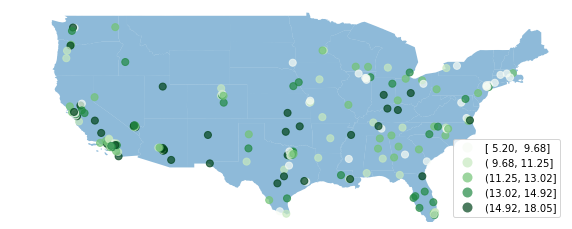

In [70]:
fig, ax = plt.subplots(figsize=(10,10))

xlim = ([states.total_bounds[0],  states.total_bounds[2]])
ylim = ([states.total_bounds[1],  states.total_bounds[3]])

ax.set_xlim(-130,-65)
ax.set_ylim(25,50)
states.plot(ax=ax,alpha = .5)
index_score.plot(column='i', ax=ax,cmap='Greens',scheme='quantiles', legend=True,marker='o',markersize = 50,alpha=0.7)
ax.set_axis_off()
plt.savefig('../img/index_score')